In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('Downloads/predictive_maintenance.csv')  

# Inspect the data
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB
None
             failure       metric1        metric2        metric3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.484762       9.940455   
std         0.029167  7.045933e+07    2179.657730     185.747321   
min         0.000000  0.0000

In [27]:
data.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [29]:
data.shape

(124494, 12)

In [31]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64


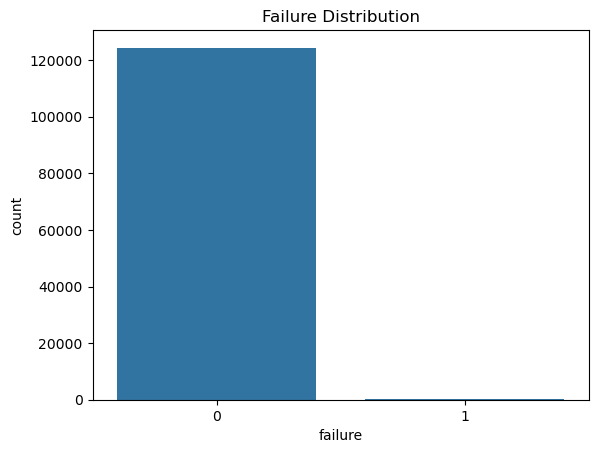

In [33]:
# Plot distribution of target variable
sns.countplot(x='failure', data=data)
plt.title('Failure Distribution')
plt.show()

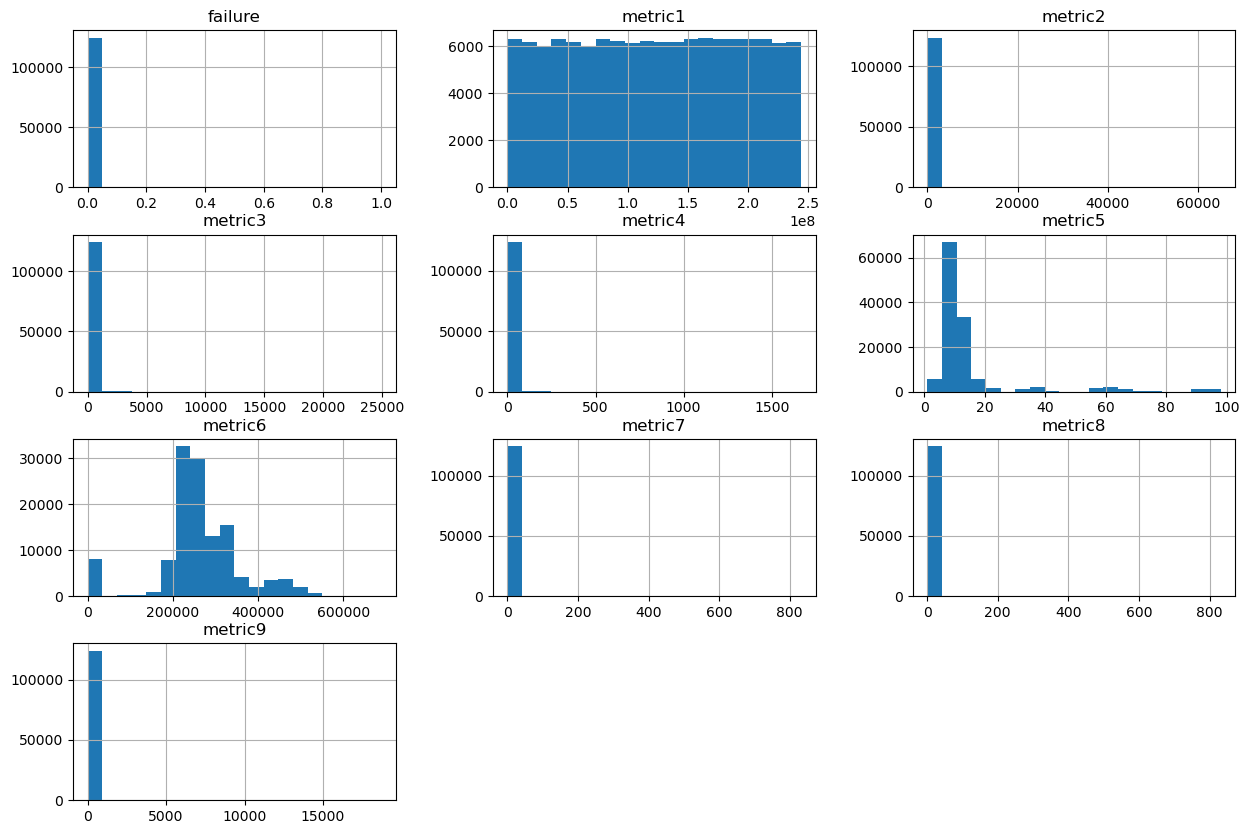

In [34]:
# Plot histograms for each feature
data.hist(bins=20, figsize=(15, 10))
plt.show()

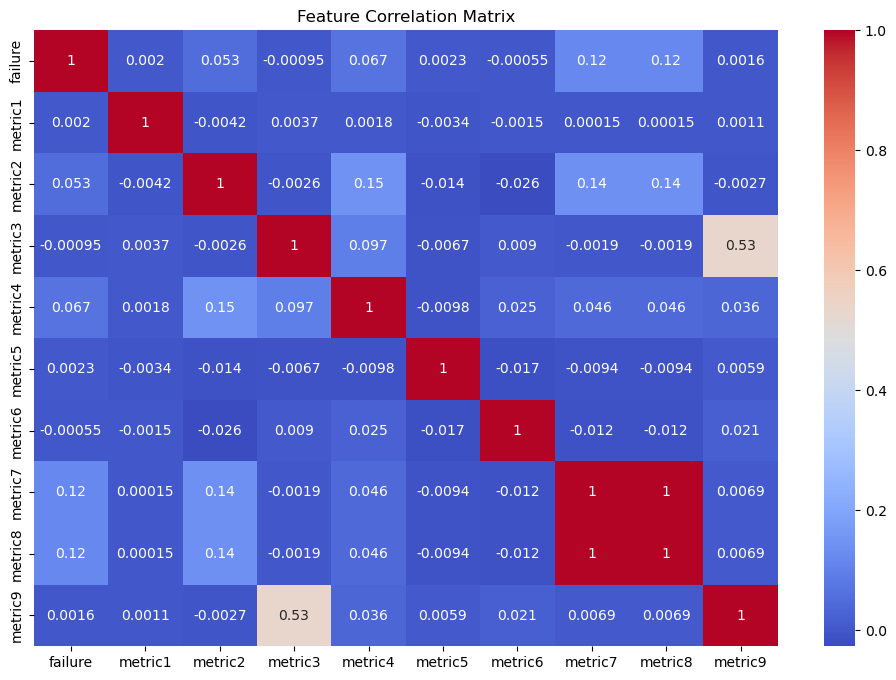

In [11]:
# Correlation matrix and heatmap
correlation_matrix = data.drop(columns=['date', 'device']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

X = data.drop(columns=['failure', 'date', 'device'])  # Drop non-feature columns
y = data['failure']  # Target variable

# 1. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [43]:
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape )

(99595, 9) (24899, 9) (99595,) (24899,)


In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [53]:
X_test_pca

array([[-0.06938812, -0.0781366 ,  0.01619935, ..., -1.2807674 ,
         0.12515653, -0.08743573],
       [-0.06314542, -0.11847027, -0.07868338, ...,  0.51336175,
        -0.54816137,  0.10887556],
       [-0.06271316, -0.11966859, -0.07033335, ...,  0.97349825,
        -0.76217792,  0.12527908],
       ...,
       [-0.06963233, -0.09723404, -0.06789164, ...,  0.02314852,
        -0.1579805 ,  0.02032178],
       [ 2.80113686, -0.23783127, -0.56410844, ...,  1.61413439,
        -0.65569367,  0.20865452],
       [-0.1002454 , -0.05170717, -0.10355647, ...,  0.02779969,
         0.98595629, -0.22934233]])

SMOTE technique with PCA

In [55]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train)

In [57]:
print(X_train_balanced.shape,y_train_balanced.shape)

(199020, 7) (199020,)


In [59]:
from collections import Counter

class_counts_after_smote = Counter(y_train_balanced)

for label, count in class_counts_after_smote.items():
    print(f"Class {label}: {count} samples")


Class 0: 99510 samples
Class 1: 99510 samples


Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.04      0.19      0.06        21

    accuracy                           1.00     24899
   macro avg       0.52      0.59      0.53     24899
weighted avg       1.00      1.00      1.00     24899

Confusion Matrix:
 [[24775   103]
 [   17     4]]


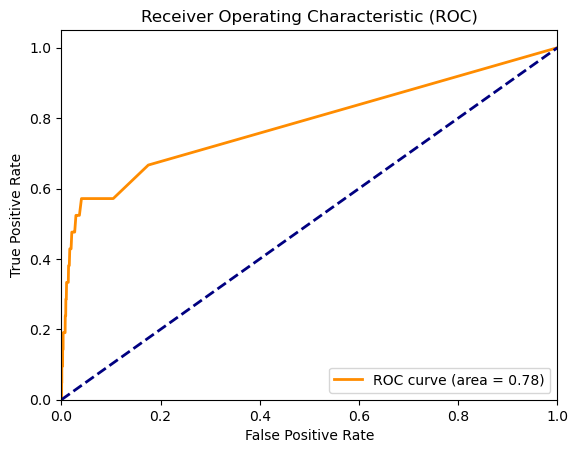

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

y_pred = rf.predict(X_test_pca)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test_pca)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


SMOTE technique without PCA

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")


X_train_scaled shape: (199014, 9)
y_train_balanced shape: (199014,)


Gradient Boosting Classifier

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     24881
           1       0.01      0.72      0.02        18

    accuracy                           0.96     24899
   macro avg       0.51      0.84      0.50     24899
weighted avg       1.00      0.96      0.98     24899

Confusion Matrix:
[[23818  1063]
 [    5    13]]


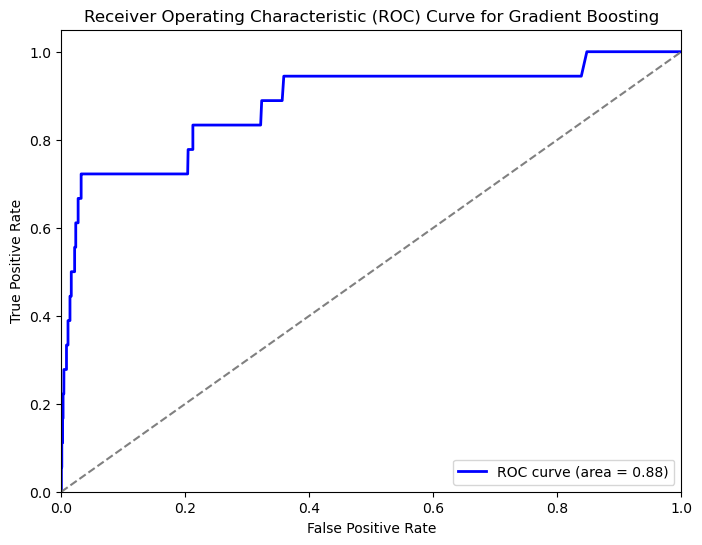

AUC: 0.88


In [75]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train_balanced)
y_pred_gb = gb_model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred_gb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]  # Get probability for class 1 (failure)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gb)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc:.2f}")


Neural Network

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

model = Sequential()
model.add(Dense(64, input_dim=X_train_balanced.shape[1], activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))  

classes = np.array([0, 1])  
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_balanced)
class_weights = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights:", class_weights)

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, 
                    validation_data=(X_test_pca, y_test), class_weight=class_weights,
                    callbacks=[early_stopping], verbose=1)

y_pred = (model.predict(X_test_pca) > 0.5).astype("int32")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.8323 - loss: 0.3781 - val_accuracy: 0.8900 - val_loss: 0.2747
Epoch 2/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9066 - loss: 0.2294 - val_accuracy: 0.9143 - val_loss: 0.2170
Epoch 3/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9233 - loss: 0.1939 - val_accuracy: 0.9292 - val_loss: 0.1757
Epoch 4/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9325 - loss: 0.1716 - val_accuracy: 0.9400 - val_loss: 0.1502
Epoch 5/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9388 - loss: 0.1601 - val_accuracy: 0.9335 - val_loss: 0.1666
Epoch 6/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9433 - loss: 0.1490 - val_accuracy: 0.9369 - val_loss: 0.1537
Epoch 7/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9456 - loss: 0.1448 - val_accuracy: 0.9316 - val_loss: 0.1610
Epoch 8/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/s